In [28]:
!python -V

Python 3.9.18


In [29]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import root_mean_squared_error
# import pyarrow.parquet as pq
import requests

import mlflow


In [30]:
mlflow.set_tracking_uri("sqlite:///nyc_ride_duration.db")
mlflow.set_experiment("ride_duration")

<Experiment: artifact_location='/home/ramcharansatyasaitejapolisetti/MachineLearning/mlops/mlflow_project/mlruns/1', creation_time=1705772086651, experiment_id='1', last_update_time=1705772086651, lifecycle_stage='active', name='ride_duration', tags={}>

In [31]:
def read_dataframe(url):
    # url = "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-10.parquet"
    response = requests.get(url)
    file_path = url.split("/")[-1]
    # "green_tripdata_2023-10.parquet"

    with open(file_path, "wb") as file:
        file.write(response.content)
    df = pd.read_parquet(file_path)
    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [32]:
df_train = read_dataframe("https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-10.parquet")
df_val = read_dataframe("https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-11.parquet")

In [33]:
# df_train['categorical'] = df_train[['PULocationID', 'DOLocationID']]
# df_val['PU_DO'] = df_val[['PULocationID', 'DOLocationID']]
# df[categorical] = df[categorical].astype('str')

In [34]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']
df_train[categorical] = df_train[categorical].astype('str')
df_val[categorical] = df_val[categorical].astype('str')

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [35]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values


In [36]:
type(y_val)

numpy.ndarray

In [37]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)
root_mean_squared_error(y_val, y_pred)


7.985611973845232

In [38]:
sns.kdeplot(y_pred, label='prediction', fill=True)
sns.kdeplot(y_val, label='actual', fill=True)

plt.legend()
plt.show()

In [ ]:
with open('model/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [ ]:
rg = Ridge()
rg.fit(X_train, y_train)

y_pred = rg.predict(X_val)
root_mean_squared_error(y_val, y_pred)

7.983225977862511

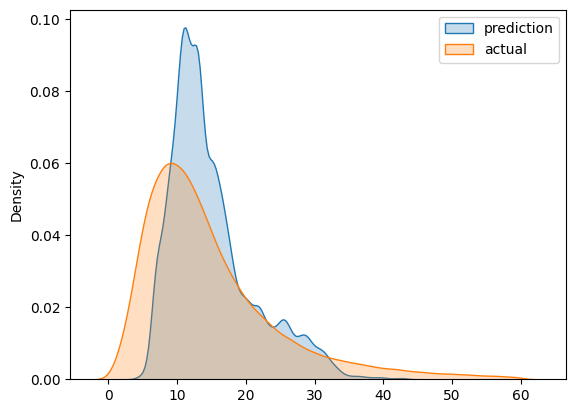

In [ ]:
sns.kdeplot(y_pred, label='prediction', fill=True)
sns.kdeplot(y_val, label='actual', fill=True)

plt.legend()
plt.show()

In [ ]:
with open('model/ridge.bin', 'wb') as f_out:
    pickle.dump((dv, rg), f_out)

In [ ]:
with mlflow.start_run():
    mlflow.set_tag('model', 'Lasso')
    mlflow.set_tag('version', 'v1')
    mlflow.set_tag('develper', 'ram_polisetti')

    alpha = 0.01
    ls = Lasso(alpha)
    ls.fit(X_train, y_train)
    y_pred = ls.predict(X_val)
    
    mlflow.log_param('alpha', 0.01)
    mlflow.log_param('train_data_path', 'green_tripdata_2023-10.parquet')
    mlflow.log_param('val_data_path', 'green_tripdata_2023-11.parquet')
    mlflow.log_metric('rmse', root_mean_squared_error(y_val, y_pred))
    mlflow.sklearn.log_model(ls, 'model')
    
    root_mean_squared_error(y_val, y_pred)

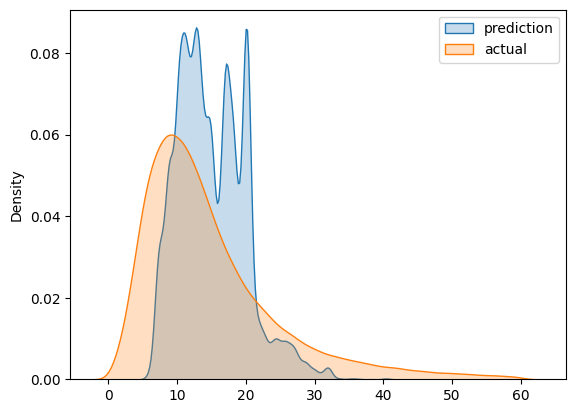

In [ ]:
sns.kdeplot(y_pred, label='prediction', fill=True)
sns.kdeplot(y_val, label='actual', fill=True)

plt.legend()
plt.show()

In [ ]:
with open('model/lasso.bin', 'wb') as f_out:
    pickle.dump((dv, ls), f_out)

## Hyper Parameter Optimization

In [ ]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll.base import scope


In [ ]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)


def objective(params):
    with mlflow.start_run():
        mlflow.set_tag('model', 'XGBoost')
        mlflow.log_param(params)
        mlflow.set_tag('develper', 'ram_polisetti')

        booster = xgb.train(params, 
                            dtrain = train, 
                            num_boost_round=1000,
                            evals=[(valid, 'validation')], 
                            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = root_mean_squared_error(y_val, y_pred)
        
        # mlflow.log_param('train_data_path', 'green_tripdata_2023-10.parquet')
        # mlflow.log_param('val_data_path', 'green_tripdata_2023-11.parquet')
        mlflow.log_metric('rmse', rmse)
        mlflow.sklearn.log_model(ls, 'model')
        
    return {'loss': rmse, 'status': STATUS_OK}
        

In [ ]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

In [ ]:
best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

--------------------                                  
  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

job exception: log_param() missing 1 required positional argument: 'value'



  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]


TypeError: log_param() missing 1 required positional argument: 'value'